# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 26
element_types = [2, 3, 4]
threshold_minutes = 85

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

# Models

## Simple Poisson model

### Preparing data

In [8]:
spm_df = element_gameweek_df.copy()

In [9]:
spm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [10]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [11]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'goals_scored')

In [12]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [13]:
spm_response_df.head()

70    0
74    0
75    0
76    1
78    1
Name: goals_scored, dtype: int64

### Fitting model

In [14]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [15]:
print(spm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 3952
Model:                            GLM   Df Residuals:                     3951
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1538.3
Date:                Sat, 23 Feb 2019   Deviance:                       2182.8
Time:                        16:28:06   Pearson chi2:                 4.38e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0999      0.045    -46.198      0.000      -2.189      -2.011


### Model fit

In [16]:
spm_results.aic

3078.601995070294

In [17]:
spm_results.bic

-30539.309065162925

In [18]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(True, 0.999998669966386)

In [19]:
spm_results.resid_deviance.describe()

count    3952.000000
mean       -0.255029
std         0.698145
min        -0.494913
25%        -0.494913
50%        -0.494913
75%        -0.494913
max         3.665510
dtype: float64

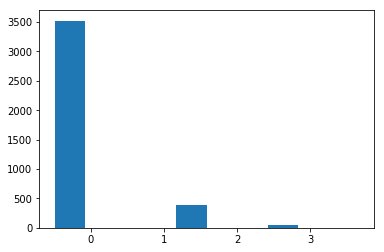

In [20]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Poisson teams model

### Preparing data

In [21]:
sptm_df = element_gameweek_df.copy()

In [22]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [23]:
sptm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [24]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [25]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'goals_scored')

In [26]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [27]:
sptm_response_df.head()

70    0
74    0
75    0
76    1
78    1
Name: goals_scored, dtype: int64

### Fitting model

In [28]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [29]:
print(sptm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 3952
Model:                            GLM   Df Residuals:                     3910
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1355.2
Date:                Sat, 23 Feb 2019   Deviance:                       1816.6
Time:                        16:28:07   Pearson chi2:                 4.20e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.3049      0.326    -10.140      0.000      -3.944      -2.666
was_home               0.156

### Model fit

In [30]:
sptm_results.aic

2794.445104832433

In [31]:
sptm_results.bic

-30565.90489598721

In [32]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(True, 0.9992772742615613)

In [33]:
sptm_results.resid_deviance.describe()

count    3952.000000
mean       -0.221619
std         0.640829
min        -1.372722
25%        -0.515232
50%        -0.344069
75%        -0.253320
max         3.557189
dtype: float64

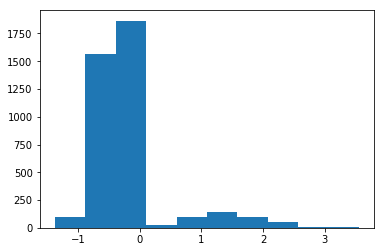

In [34]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Poisson player model

### Preparing data

In [35]:
sppm_df = element_gameweek_df.copy()

In [36]:
sppm_df = player.add_categorical_variables(sppm_df, 'element_type')
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [37]:
sppm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [38]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [39]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'goals_scored')

In [40]:
sppm_explanatory_df.columns

Index(['const', 'element_type_3', 'element_type_4', 'opposition_team_2',
       'opposition_team_3', 'opposition_team_4', 'opposition_team_5',
       'opposition_team_6', 'opposition_team_7', 'opposition_team_8',
       ...
       'element_535', 'element_539', 'element_549', 'element_556',
       'element_565', 'element_570', 'element_571', 'element_575',
       'element_579', 'element_591'],
      dtype='object', length=391)

In [41]:
sppm_response_df.head()

70    0
74    0
75    0
76    1
78    1
Name: goals_scored, dtype: int64

### Fitting model

In [42]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [43]:
print(sppm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 3952
Model:                            GLM   Df Residuals:                     3563
Model Family:                 Poisson   Df Model:                          388
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1111.7
Date:                Sat, 23 Feb 2019   Deviance:                       1329.6
Time:                        16:28:16   Pearson chi2:                 2.21e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.3364      0.754     -1.771      0.076      -2.815       0.142
element_type_3       -12.762

### Model fit

In [44]:
sppm_results.aic

3001.380666659371

In [45]:
sppm_results.bic

-28179.12329473316

In [46]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(False, 4.6434294256207625e-78)

In [47]:
sppm_results.resid_deviance.describe()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


count    3948.000000
mean       -0.139688
std         0.563326
min        -1.458262
25%        -0.459142
50%        -0.213228
75%        -0.000001
max         2.705821
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


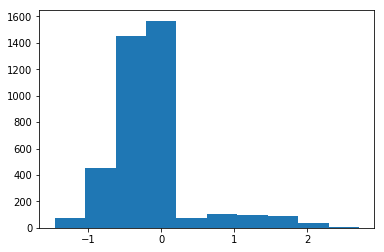

In [48]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Poisson player model with team-home interactions

### Preparing data

In [54]:
sphm_df = element_gameweek_df.copy()

In [55]:
sphm_df = player.add_categorical_variables(sphm_df, 'element_type')
sphm_df = player.add_categorical_variables(sphm_df, 'opposition_team')
sphm_df = player.add_categorical_variables(sphm_df, 'element')

In [56]:
sphm_df = player.add_interaction_terms(sphm_df, 'opposition_team', 'was_home')

In [57]:
sphm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [58]:
sphm_df = player.remove_redundant_columns(sphm_df, sphm_redundant_columns)

In [59]:
sphm_response_df, sphm_explanatory_df = player.get_response_explanatory_dfs(sphm_df, 'goals_scored')

In [60]:
sphm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       ...
       'opposition_team_was_home_11', 'opposition_team_was_home_12',
       'opposition_team_was_home_13', 'opposition_team_was_home_14',
       'opposition_team_was_home_15', 'opposition_team_was_home_16',
       'opposition_team_was_home_17', 'opposition_team_was_home_18',
       'opposition_team_was_home_19', 'opposition_team_was_home_20'],
      dtype='object', length=411)

In [61]:
sphm_response_df.head()

70    0
74    0
75    0
76    1
78    1
Name: goals_scored, dtype: int64

### Fitting model

In [62]:
sphm_results = sm.GLM(
    sphm_response_df,
    sphm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [63]:
print(sphm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                 3952
Model:                            GLM   Df Residuals:                     3543
Model Family:                 Poisson   Df Model:                          408
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1102.2
Date:                Sat, 23 Feb 2019   Deviance:                       1310.6
Time:                        16:30:09   Pearson chi2:                 2.18e+03
No. Iterations:                    25                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.8312      0.847     -2.161      0.031      -3.492      -0.170
w

### Model fit

In [64]:
sphm_results.aic

3022.465689149022

In [65]:
sphm_results.bic

-28032.398731066154

In [66]:
sphm_pearson_results = goodness_fit.pearson_chi_squared_test(sphm_results)
sphm_pearson_results

(False, 1.1346605574959228e-79)

In [67]:
sphm_results.resid_deviance.describe()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


count    3949.000000
mean       -0.138309
std         0.559324
min        -1.424218
25%        -0.453218
50%        -0.189237
75%        -0.000001
max         2.434043
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


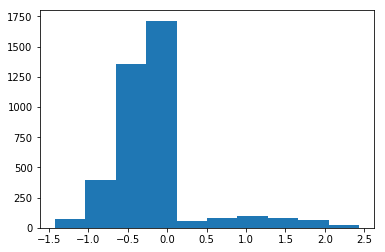

In [68]:
plt.figure()
plt.hist(sphm_results.resid_deviance)
plt.show()

## Simple Gaussian model

### Preparing data

In [71]:
sgm_df = element_gameweek_df.copy()

In [72]:
sgm_redundant_columns = [
    'row_id', 'assists', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [73]:
sgm_df = player.remove_redundant_columns(sgm_df, sgm_redundant_columns)

In [74]:
sgm_response_df, sgm_explanatory_df = player.get_response_explanatory_dfs(sgm_df, 'goals_scored')

### Fitting model

In [75]:
sgm_results = sm.GLM(
    sgm_response_df,
    sgm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [76]:
print(sgm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:           goals_scored   No. Observations:                  3952
Model:                            GLM   Df Residuals:                      3950
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.13573081294926206
Method:                          IRLS   Log-Likelihood:                 -1660.4
Date:                Sat, 23 Feb 2019   Deviance:                        536.14
Time:                        16:30:26   Pearson chi2:                      536.
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1103      0.008     13.342      0.000       0.094       0.127
was_home       0.0244      0.012      2.081

### Model fit

In [77]:
sgm_results.aic

3324.8228955001177

In [78]:
sgm_results.bic

-32177.67267137806

In [79]:
goodness_fit.pearson_chi_squared_test(sgm_results)

(False, 0.0)

In [80]:
sgm_results.resid_deviance.describe()

count    3.952000e+03
mean     1.078759e-16
std      3.683700e-01
min     -1.347229e-01
25%     -1.347229e-01
50%     -1.103275e-01
75%     -1.103275e-01
max      2.889673e+00
dtype: float64

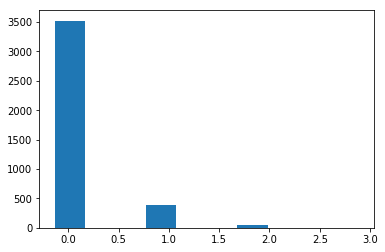

In [81]:
plt.figure()
plt.hist(sgm_results.resid_deviance)
plt.show()

# Model comparison

In [85]:
spm_results.aic, sptm_results.aic, sppm_results.aic, sphm_results.aic, sgm_results.aic

(3078.601995070294,
 2794.445104832433,
 3001.380666659371,
 3022.465689149022,
 3324.8228955001177)

In [86]:
spm_results.bic, sptm_results.bic, sppm_results.bic, sphm_results.bic, sgm_results.bic

(-30539.309065162925,
 -30565.90489598721,
 -28179.12329473316,
 -28032.398731066154,
 -32177.67267137806)

In [87]:
spm_pearson_results, sptm_pearson_results, sppm_pearson_results, sphm_pearson_results

((True, 0.999998669966386),
 (True, 0.9992772742615613),
 (False, 4.6434294256207625e-78),
 (False, 1.1346605574959228e-79))